# RFI Inspection Daily RTP Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
from astropy import units
from copy import deepcopy
from pyuvdata import UVFlag
#from SSINS import INS
#from SSINS import version as SSINS_ver
import matplotlib.colors as colors
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
# Use environment variables to figure out path to data
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
print(f'JD = {JD}')
print(f'data_path = "{data_path}"')
JD = int(JD)

KeyError: 'JULIANDATE'

In [30]:
# For testing purposes only.
JD = 2458937 # this day has the interesting reverse-FRB feature
data_path = f"/lustre/aoc/projects/hera/H3C/IDR3_1/{JD}"
# JD = 2459122 # per AEW's request
# data_path = f"/lustre/aoc/projects/hera/H4C/{JD}"

In [31]:
uvf = UVFlag(f'{data_path}/zen.{JD}.total_threshold_flags.h5')

# Load in the metadata for easier plotting.
freqs = np.unique(uvf.freq_array)
times = np.unique(uvf.time_array)
lsts = np.unique(uvf.lst_array)
chans = np.arange(freqs.size)
plot_times = times - np.floor(times[0])
lsts_hr = lsts * units.rad.to("cycle") * units.day.to("hr")
freqs_MHz = freqs * units.Hz.to("MHz")
extent = (freqs_MHz[0], freqs_MHz[-1], plot_times[-1], plot_times[0])

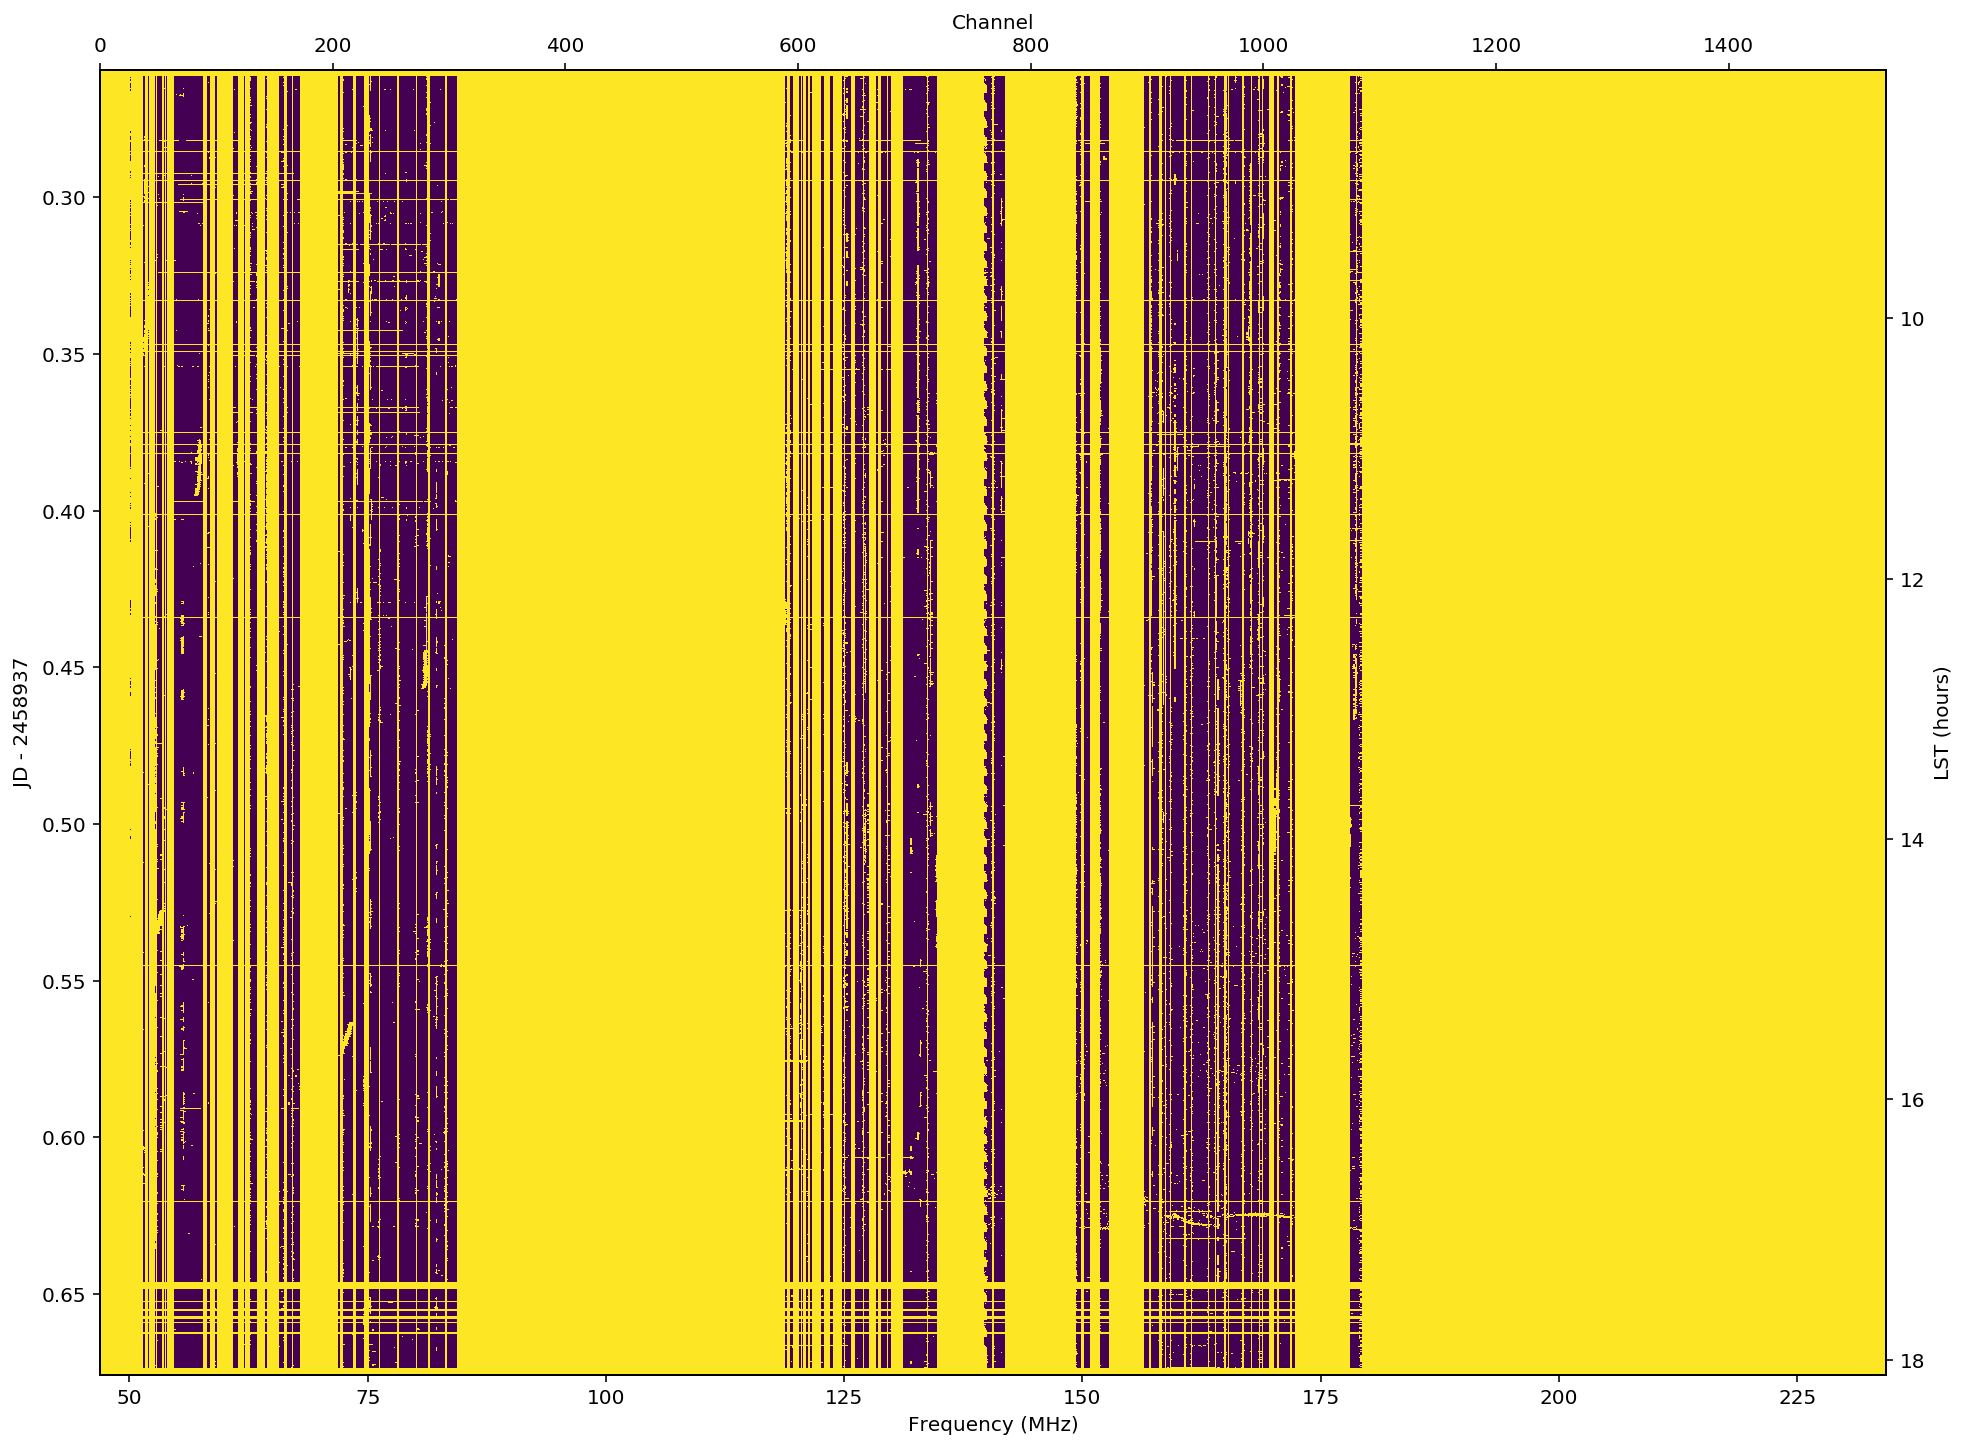

In [32]:
plt.figure(figsize=(16,12))
cax = plt.imshow(uvf.flag_array[:,:,0], aspect='auto', interpolation='nearest',
           extent=[uvf.freq_array[0] / 1e6, uvf.freq_array[-1] / 1e6, 
                   uvf.time_array[-1] - JD, uvf.time_array[0] - JD])
plt.xlabel('Frequency (MHz)')
plt.ylabel(f'JD - {JD}')
ax2 = plt.gca().twinx()
ax2.set_ylim([uvf.lst_array[0] * 12 / np.pi, uvf.lst_array[-1] * 12 / np.pi])
ax2.invert_yaxis()
ax2.set_ylabel('LST (hours)')
ax3 = plt.gca().twiny()
ax3.set_xlim([0, uvf.Nfreqs - 1])
ax3.set_xlabel('Channel');

# Figure 1(a): Full day of XRFI flags
Yellow is flagged. Blue is unflagged.

In [33]:
xrfi_dirs = sorted(glob.glob(f'{data_path}/zen.{JD}.?????.xrfi'))
print(f'Found {len(xrfi_dirs)} directories containing XRFI intermediate data products.')
files1 = [glob.glob(f'{d}/*combined_metrics1.h5')[0] for d in xrfi_dirs]
print(f'Found {len(files1)} combined round 1 XRFI metrics files.')
files2 = [glob.glob(f'{d}/*combined_metrics2.h5')[0] for d in xrfi_dirs]
print(f'Found {len(files2)} combined round 2 XRFI metrics files.')
uvf1 = UVFlag(files1)
uvf2 = UVFlag(files2)
uvf2.metric_array = np.where(np.isinf(uvf2.metric_array), uvf1.metric_array,
                             uvf2.metric_array)

Found 1862 directories containing XRFI intermediate data products.
Found 1862 combined round 1 XRFI metrics files.
Found 1862 combined round 2 XRFI metrics files.


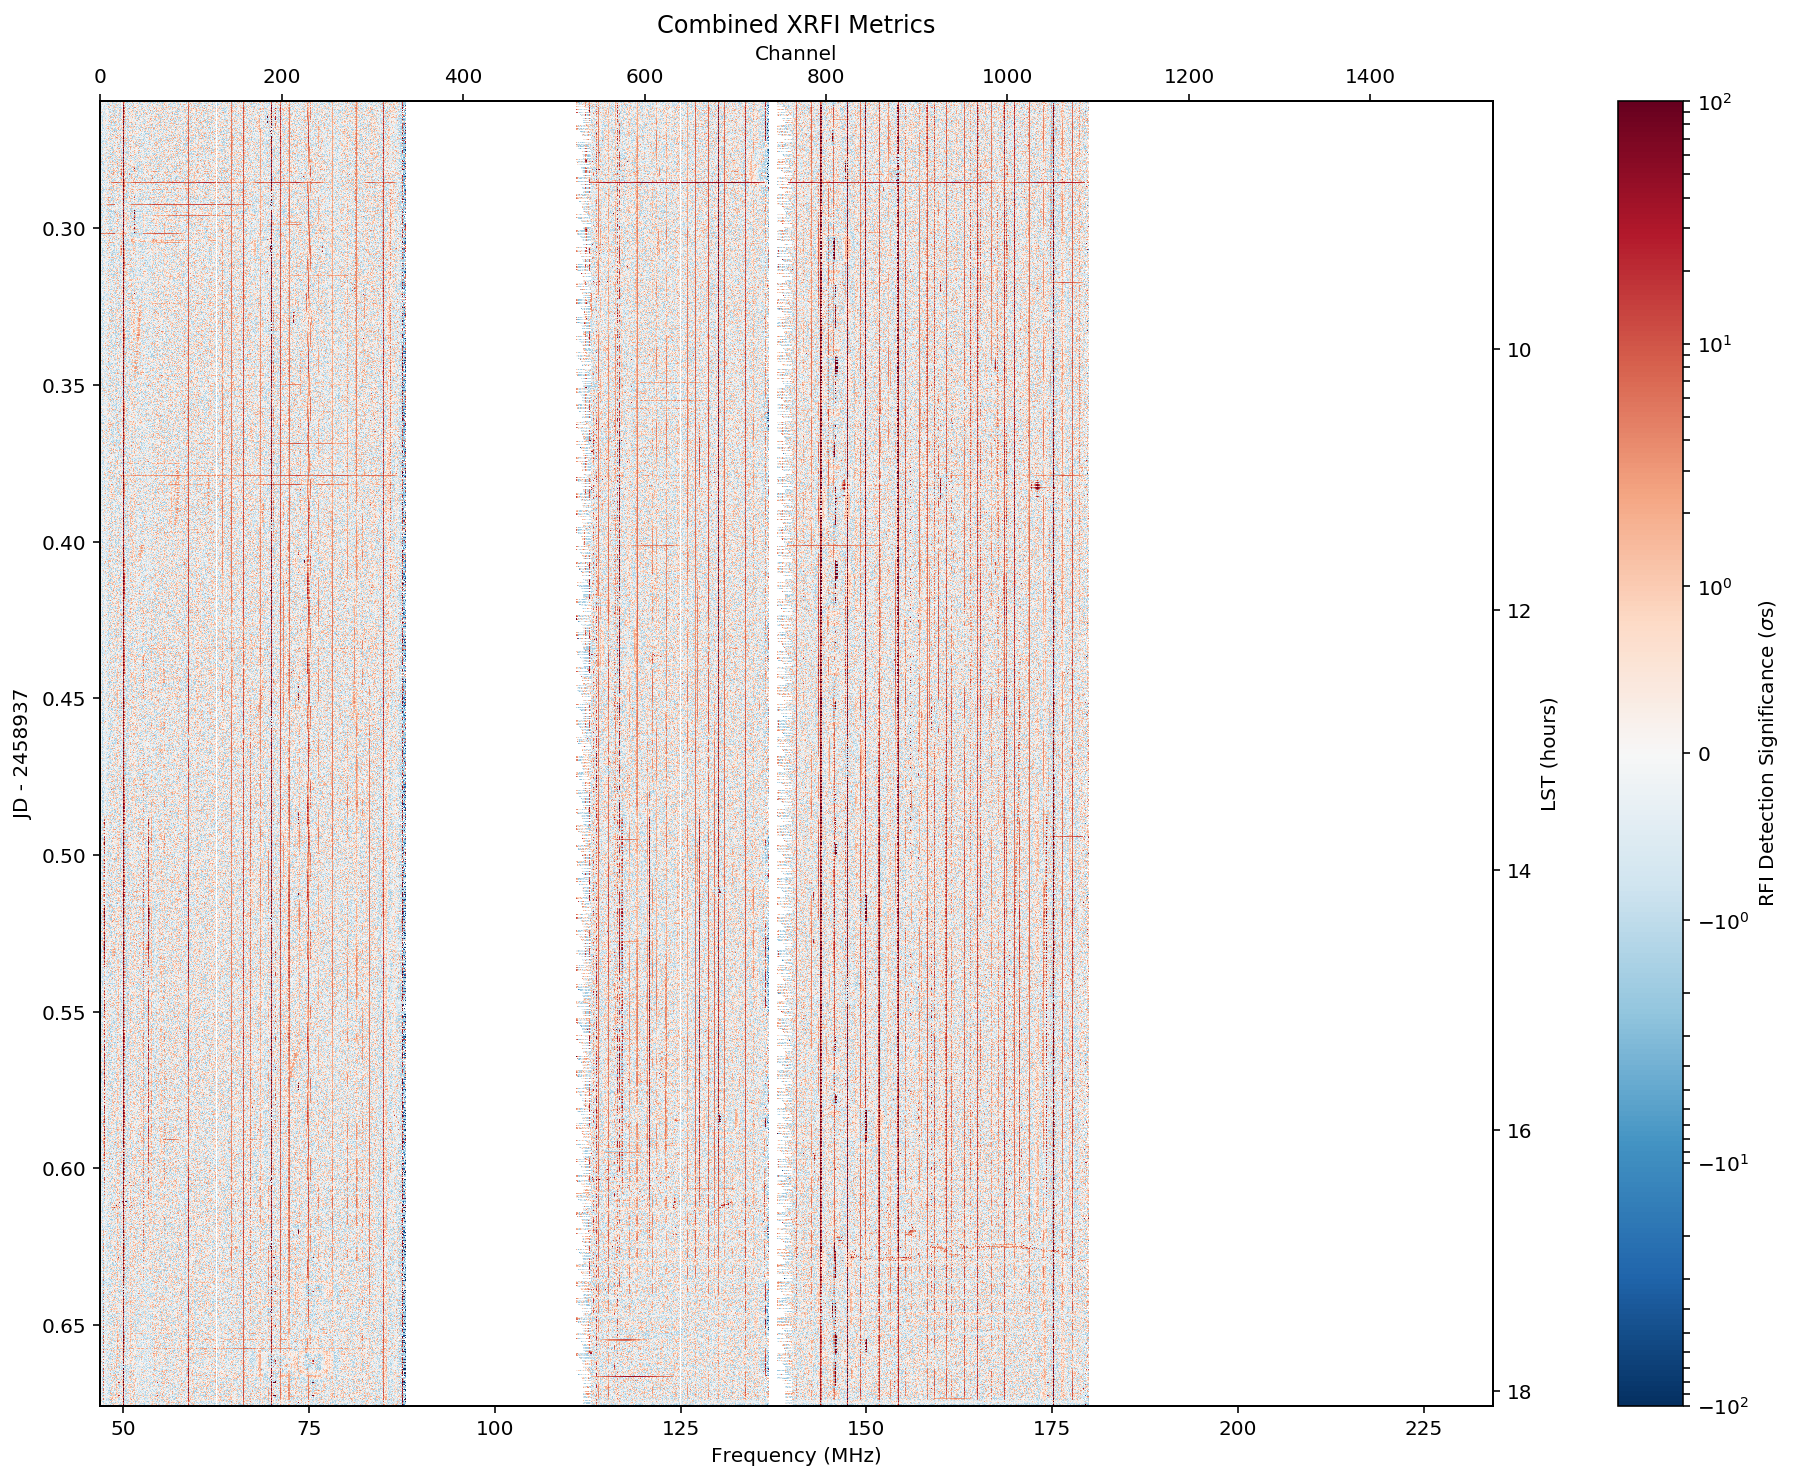

In [34]:
plt.figure(figsize=(16,12))
max_abs = 100
if np.max(uvf2.metric_array) > max_abs:
    extend = 'max'
    if np.min(uvf2.metric_array) < -max_abs:
        extend = 'both'
elif np.min(uvf2.metric_array) < -max_abs:
    extend = 'min'    
else:
    extend = 'neither'

plt.imshow(uvf2.metric_array[:,:,0], aspect='auto', cmap='RdBu_r',
           norm=colors.SymLogNorm(linthresh=1,vmin=-max_abs, vmax=max_abs), 
           extent=[uvf.freq_array[0] / 1e6, uvf.freq_array[-1] / 1e6, 
                   uvf.time_array[-1] - JD, uvf.time_array[0] - JD])
plt.colorbar(pad=.07, extend=extend,
             label='RFI Detection Significance ($\sigma$s)')
plt.title('Combined XRFI Metrics')
plt.xlabel('Frequency (MHz)')
plt.ylabel(f'JD - {JD}')
ax2 = plt.gca().twinx()
ax2.set_ylim([uvf.lst_array[0] * 12 / np.pi, uvf.lst_array[-1] * 12 / np.pi])
ax2.invert_yaxis()
ax2.set_ylabel('LST (hours)')
ax3 = plt.gca().twiny()
ax3.set_xlim([0, uvf.Nfreqs - 1])
ax3.set_xlabel('Channel');

## Figure 2(a): Combined XRFI Detection Significance
This figure shows round 2 XRFI metrics (mean filter outliers) combined in quadrature. When flagged in round 1 of XRFI, round 1's combined median filter metrics are used instead. 

In [35]:
# Load in the flags from each round of XRFI flagging.
low_level_flag_labels = (
    "apriori_flags",
    "auto_flags1",
    "auto_flags2",
    "flags1",
    "flags2",
    "og_flags1",
    "og_flags2",
    "ox_flags1",
    "ox_flags2",
    "v_flags1",
    "v_flags2",
#    "cross_flags2",
)
# Keep the thresholded flags separate for easier analysis.
thresholded_flag_labels = (
    "auto_threshold_flags",
#    "cross_threshold_flags",
#    "combined_threshold_flags",
    "og_threshold_flags",
    "ox_threshold_flags",
    "v_threshold_flags",
#    "total_threshold_flags",
)

low_level_flags = {}
for file_id in low_level_flag_labels:
    flag_files = [
        glob.glob(os.path.join(xrfi_dir, f"*.sum.{file_id}.h5"))[0]
        for xrfi_dir in xrfi_dirs
    ]
    uvf = UVFlag(flag_files)
    low_level_flags[file_id] = uvf.flag_array[...,0]
    
thresholded_flags = {}
for file_id in thresholded_flag_labels:
    flag_file = f"{data_path}/zen.{JD}.{file_id}.h5"
    uvf = UVFlag(flag_file)
    thresholded_flags[file_id] = uvf.flag_array[...,0]

In [36]:
label_mapping = {
    f"Round {i}": {
        "Priors": ("apriori_flags", "flags1")[i-1],
        "Autocorrelations": f"auto_flags{i}",
        "Omnical Gains": f"og_flags{i}",
        r"Omnical $\chi^2$": f"ox_flags{i}",
        "Omnical Visibilities": f"v_flags{i}",
    } for i in (1,2)
}

In [37]:
unique_flags_by_stage = {}
for round_label, mapping in label_mapping.items():
    unique_flags_by_stage[round_label] = {}
    overlap_flags = np.zeros_like(uvf.flag_array[...,0])
    prior_flags = low_level_flags[mapping["Priors"]]
    unique_flags_by_stage[round_label]["Priors"] = prior_flags
    for label, file_id in mapping.items():
        if label == "Priors":
            continue
        flags = low_level_flags[file_id]
        unique_flags = flags.copy()
        for other_label, other_file_id in mapping.items():
            if label == other_label:
                continue
            other_flags = low_level_flags[other_file_id]
            unique_flags &= ~other_flags
            overlap_region = flags & other_flags & ~prior_flags
            overlap_flags[overlap_region] = True
        unique_flags_by_stage[round_label][label] = unique_flags
    unique_flags_by_stage[round_label]["Multiple Sources"] = overlap_flags

In [38]:
pastel_palette = ( 
    "paleturquoise",
    "plum",
    "lemonchiffon",
    "palegreen",
    "azure",
    "mistyrose",
    "bisque",
)
background_color = "slategrey"
color_palette = (background_color,) + pastel_palette
cmap_labels = ("Unflagged",) + tuple(unique_flags_by_stage["Round 1"].keys())
cmap = plt.cm.colors.ListedColormap(color_palette[:len(cmap_labels)])
norm = plt.cm.colors.Normalize(vmin=0, vmax=1)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
colored_flags = {}
for round_label, flag_dict in unique_flags_by_stage.items():
    colored_flags[round_label] = np.zeros(uvf.flag_array[...,0].shape)
    for label, flags in flag_dict.items():
        colored_flags[round_label][flags] = cmap_labels.index(label) / (len(cmap_labels) - 1)

In [44]:
# Plot flags in the low-band.
fig, axes = plt.subplots(
    len(colored_flags), figsize=(15, 10 * len(colored_flags)), dpi=300
)
freq_slice = np.argwhere(freqs_MHz < 90).flatten()  # Low-band, pre-FM
tmin, tmax = plot_times[0], plot_times[-1]
lstmin, lstmax = lsts_hr[0], lsts_hr[-1]
fmin, fmax = freqs_MHz[freq_slice][::freq_slice.size - 1]
extent = (fmin, fmax, tmax, tmin)
for ax, (label, flags) in zip(axes, colored_flags.items()):
    ax.set_title(label, fontsize=16)
    ax.imshow(
        flags[:,freq_slice], aspect="auto", extent=extent, cmap=cmap, vmin=0, vmax=1
    )
    twinx = ax.twinx()
    twiny = ax.twiny()
    twinx.set_ylim(lstmax, lstmin)
    twiny.set_xlim(freq_slice[0], freq_slice[-1])
    ax.set_xlabel("Frequency (MHz)", fontsize=12)
    ax.set_ylabel(f"JD - {JD}", fontsize=12)
    twinx.set_ylabel("LST (hour)", fontsize=12)
    twiny.set_xlabel("Channel", fontsize=12)
    
fig.tight_layout()
cbar = fig.colorbar(smap, ax=axes)
cbar.set_ticks(np.linspace(0, 1, 2 * len(cmap.colors) + 1)[1::2])
cbar.set_ticklabels(cmap_labels)

## Figure 3: Flag Evolution in the Low Band
This figure delineates which steps different flags are introduced in, but does not make a distinction between sources when multiple flagging routines flag the same region of the waterfall. The plot shows flags for frequencies below the FM band, for the entire night. The top plot shows the flags for the first round of flagging&mdash;where the prior flags are the apriori flags&mdash;and the bottom plot shows the flags for the second round of flagging, where the prior flags are the combined flags from the first round of flagging.

In [45]:
# Plot flags in the mid-band.
fig, axes = plt.subplots(
    len(colored_flags), figsize=(15, 10 * len(colored_flags)), dpi=300
)

# Figure out the details for which part of the flag arrays to plot.
freq_slice = np.argwhere(
    np.logical_and(freqs_MHz > 110, freqs_MHz < 185)
).flatten()  # Mid-band: post-FM, pre-TV
fmin, fmax = freqs_MHz[freq_slice][::freq_slice.size - 1]
extent = (fmin, fmax, tmax, tmin)

# Actually plot the things.
for ax, (label, flags) in zip(axes, colored_flags.items()):
    ax.set_title(label, fontsize=16)
    ax.imshow(
        flags[:,freq_slice], aspect="auto", extent=extent, cmap=cmap, vmin=0, vmax=1
    )
    twinx = ax.twinx()
    twiny = ax.twiny()
    twinx.set_ylim(lstmax, lstmin)
    twiny.set_xlim(freq_slice[0], freq_slice[-1])
    ax.set_xlabel("Frequency (MHz)", fontsize=12)
    ax.set_ylabel(f"JD - {JD}", fontsize=12)
    twinx.set_ylabel("LST (hour)", fontsize=12)
    twiny.set_xlabel("Channel", fontsize=12)
    
fig.tight_layout()
cbar = fig.colorbar(smap, ax=axes)
cbar.set_ticks(np.linspace(0, 1, 2 * len(cmap.colors) + 1)[1::2])
cbar.set_ticklabels(cmap_labels)

## Figure 4: Flag Evolution in the Mid-Band
This figure delineates which steps different flags are introduced in, but does not make a distinction between sources when multiple flagging routines flag the same region of the waterfall. The plot shows flags for frequencies between the FM band and the analog TV band, for the entire night. The top plot shows the flags for the first round of flagging&mdash;where the prior flags are the apriori flags&mdash;and the bottom plot shows the flags for the second round of flagging, where the prior flags are the combined flags from the first round of flagging.

In [41]:
# TODO: make a new flagging occupancy plot, but first figure out how to delineate things

## Figure 5: Flagging Occupancies
The top plot shows the fraction of channels flagged at each integration for each set of flags. The bottom plot shows the fraction of integrations flagged as a function of frequency for the total thresholded flags.

# Metadata

In [42]:
from hera_qm import version
print(version.construct_version_info())

{'version': '1.0', 'git_origin': 'https://github.com/HERA-Team/hera_qm', 'git_hash': '597ec3b498ce1b30cbef2736df1addfc4a6b9ffe', 'git_description': 'H1C_IDR2.1-785-g597ec3b', 'git_branch': 'master'}


In [46]:
#print(f"SSINS version info: {SSINS_ver.construct_version_info()}")